In [1]:
import cv2
import numpy as np
import pandas as pd
import open3d as o3d
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import utils
import calibration_utils

import importlib
importlib.reload(utils)
importlib.reload(calibration_utils)

<module 'calibration_utils' from '/home/tom/Documents/UNT/csce6260/projects/kitti-experiments/fusion/calibration_utils.py'>

### Load data

In [3]:
base = Path.home() / "kitti"
train_dir = base / "training"
train_img_dir = train_dir / "image_2"
kitti_images_train = sorted(train_img_dir.glob("*.png"))
train_labels_dir = train_dir / "label_2"
kitti_train_labels = sorted(train_labels_dir.glob("*.txt"))
velo_dir = train_dir / "velodyne"
point_cloud_train_files = sorted(velo_dir.glob("*.bin"))
calib_dir = train_dir / "calib"
calib_train_files = sorted(calib_dir.glob("*.txt"))

Sample Image Path: /home/tom/kitti/training/image_2/005902.png



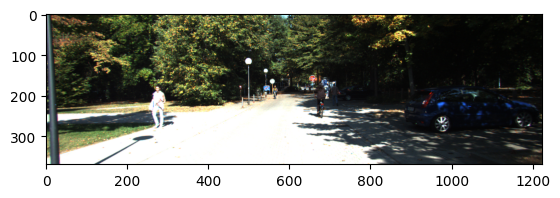

In [4]:
analysis_file_index = 5902
sample_image_path = kitti_images_train[analysis_file_index]
print(f"Sample Image Path: {sample_image_path}\n")
sample_image = cv2.imread(sample_image_path)
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image_rgb)

In [5]:
bin_path = point_cloud_train_files[analysis_file_index]
print("Sample Cloud File Path: {}\n".format(bin_path))
points_velo = utils.read_velodyne_bin(bin_path)
print('--> .bin File Content\n')
print(points_velo[:3])

Sample Cloud File Path: /home/tom/kitti/training/velodyne/005902.bin

--> .bin File Content

[[77.704  0.169  2.837  0.   ]
 [78.408  1.649  2.861  0.   ]
 [77.905  4.089  2.847  0.   ]]


In [6]:
calib = utils.parse_calib_file(calib_train_files[analysis_file_index])
print("Calibration data:")
print(calib)

Calibration data:
{'P0': array([[707.0493,   0.    , 604.0814,   0.    ],
       [  0.    , 707.0493, 180.5066,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]], dtype=float32), 'P1': array([[ 707.0493,    0.    ,  604.0814, -379.7842],
       [   0.    ,  707.0493,  180.5066,    0.    ],
       [   0.    ,    0.    ,    1.    ,    0.    ]], dtype=float32), 'P2': array([[ 7.070493e+02,  0.000000e+00,  6.040814e+02,  4.575831e+01],
       [ 0.000000e+00,  7.070493e+02,  1.805066e+02, -3.454157e-01],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  4.981016e-03]],
      dtype=float32), 'P3': array([[ 7.070493e+02,  0.000000e+00,  6.040814e+02, -3.341081e+02],
       [ 0.000000e+00,  7.070493e+02,  1.805066e+02,  2.330660e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  3.201153e-03]],
      dtype=float32), 'R0': array([[ 0.9999128 ,  0.01009263, -0.00851193],
       [-0.01012729,  0.9999406 , -0.00403767],
       [ 0.00847067,  0.00412352,  0.9999556 ]], dtype=

### Output ground-truth 2d object detections

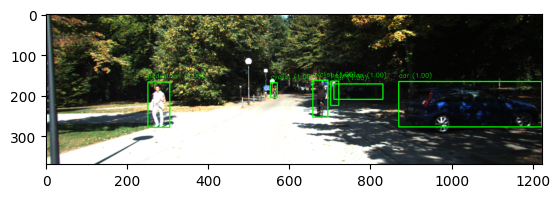

In [7]:
sample_label = utils.parse_label_file(kitti_train_labels[analysis_file_index])

gt_detections = []
for label in sample_label:
    class_name = label["type"].lower()
    if class_name != "dontcare":
        x_min, y_min, x_max, y_max = label["bbox_2d"]
        gt_detections.append({
            "bounding_box": [x_min, y_min, x_max, y_max],
            "object_name": class_name.lower(),
            "confidence": float(1.0)
        })

gt_image = utils.draw_detection_output(sample_image_rgb, gt_detections, color_rgb=(0, 255, 0))
plt.imshow(gt_image);

### Voxel downsampling

In [8]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_velo[:, :3])
print("Original:", np.asarray(pcd.points).shape)
pcd = pcd.voxel_down_sample(voxel_size=0.2)
print("Downsampled:", np.asarray(pcd.points).shape)

Original: (122794, 3)
Downsampled: (33122, 3)


### RANSAC Segmentation

In [9]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.3, ransac_n=3, num_iterations=150)
inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([0, 1, 1])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
outlier_cloud.paint_uniform_color([1, 0, 0])

PointCloud with 17862 points.

### Depth Filtering

In [10]:
outlier_points = np.array(outlier_cloud.points)
print(f"Number of outlier points: {len(outlier_points)}")
mask_in_front = outlier_points[:, 0] > 0
outliers_in_front_of_cam = outlier_points[mask_in_front]
print(f"Number of outlier points in front of camera: {len(outliers_in_front_of_cam)}")

Number of outlier points: 17862
Number of outlier points in front of camera: 8354


### Extract frustums

In [11]:
points_img_coords = calibration_utils.convert_to_img_coords(outliers_in_front_of_cam, calib)
u = points_img_coords[:, 0]
v = points_img_coords[:, 1]

frustums = []
for gt_det in gt_detections:
    xmin, ymin, xmax, ymax = gt_det['bounding_box']
    mask_frustum = (u >= xmin) & (u <= xmax) & (v >= ymin) & (v <= ymax)
    valid_mask = np.isfinite(u) & np.isfinite(v)
    mask_frustum = mask_frustum & valid_mask
    frustum_points = outliers_in_front_of_cam[mask_frustum]
    frustums.append(frustum_points)

In [12]:
def print_frustum_info(frustum_points):
    print(f"Number of frustum points: {frustum_points.shape[0]}")
    print('Min/Max values for all dimensions')
    min_x, max_x = np.min(frustum_points[:, 0]), np.max(frustum_points[:, 0])
    min_y, max_y = np.min(frustum_points[:, 1]), np.max(frustum_points[:, 1])
    min_z, max_z = np.min(frustum_points[:, 2]), np.max(frustum_points[:, 2])
    print(f"X (forward): ({min_x:.2f}, {max_x:.2f})")
    print(f"Y (left): ({min_y:.2f}, {max_y:.2f})")
    print(f"Z (up): ({min_z:.2f}, {max_z:.2f})\n")

object_names = []
object_instances = Counter()
for gt_det in gt_detections:
    object_name = gt_det['object_name']
    object_instances[object_name] += 1
    object_names.append(f"{object_name.capitalize()} #{object_instances[object_name]}")

for i, frustum_points in enumerate(frustums):
    print(f"Object Name: {object_names[i]}")
    print_frustum_info(frustum_points)

Object Name: Pedestrian #1
Number of frustum points: 150
Min/Max values for all dimensions
X (forward): (11.36, 39.59)
Y (left): (4.92, 19.42)
Z (up): (-1.49, 0.65)

Object Name: Cyclist #1
Number of frustum points: 97
Min/Max values for all dimensions
X (forward): (14.33, 68.19)
Y (left): (-6.88, -1.18)
Z (up): (-1.70, 0.90)

Object Name: Car #1
Number of frustum points: 493
Min/Max values for all dimensions
X (forward): (8.68, 61.24)
Y (left): (-47.71, -3.92)
Z (up): (-1.35, 0.41)

Object Name: Cyclist #2
Number of frustum points: 23
Min/Max values for all dimensions
X (forward): (35.74, 53.54)
Y (left): (1.75, 3.50)
Z (up): (-1.19, 0.38)

Object Name: Pedestrian #2
Number of frustum points: 44
Min/Max values for all dimensions
X (forward): (22.08, 66.17)
Y (left): (-10.80, -3.09)
Z (up): (-0.92, 0.42)

Object Name: Car #2
Number of frustum points: 174
Min/Max values for all dimensions
X (forward): (20.94, 65.83)
Y (left): (-18.23, -3.26)
Z (up): (-0.92, 0.13)



### Cluster frustums

In [13]:
def get_frustum(frustum_points):
    frustum = o3d.geometry.PointCloud()
    frustum.points = o3d.utility.Vector3dVector(frustum_points[:, :3])
    return frustum

def get_cluster_labels(frustum):
    with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
        cluster_labels = np.array(frustum.cluster_dbscan(eps=0.45, min_points=10, print_progress=True))
    return cluster_labels

def get_frustum_colors(cluster_labels):
    max_cluster_label = cluster_labels.max()
    colors = plt.get_cmap("tab20")(cluster_labels / (max_cluster_label if max_cluster_label > 0 else 1))
    colors[cluster_labels < 0] = 0
    return o3d.utility.Vector3dVector(colors[:, :3])

def group_cluster_labels(cluster_labels):
    valid_mask = cluster_labels != -1
    return (
        pd.Series(np.arange(len(cluster_labels)))[valid_mask]
        .groupby(cluster_labels[valid_mask], sort=False)
        .apply(list)
        .tolist()
    )

def get_frustum_with_clusters(frustum_points):
    frustum = get_frustum(frustum_points)
    cluster_labels = get_cluster_labels(frustum)
    frustum.colors = get_frustum_colors(cluster_labels)
    return frustum, group_cluster_labels(cluster_labels)

frustums_with_clusters = []
for i, frustum_points in enumerate(frustums):
    frustum, clusters = get_frustum_with_clusters(frustum_points)
    frustums_with_clusters.append((frustum, clusters,))

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 5
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 3
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 1
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 1
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 3
Precompute neighbors.[========================================] 100%
Precompute neighbors.[===

### Generate 3d bounding boxes

In [14]:
def get_cluster_predictions(frustum, clusters, min_points=25, max_points=300):
    pred_clusters = []
    for cluster_idx in clusters:
        cluster = frustum.select_by_index(cluster_idx)
        if min_points < len(cluster.points) < max_points:
            pred_clusters.append(cluster)
    return pred_clusters

def get_axis_aligned_bounding_box(cluster, color):
    axis_aligned_box = cluster.get_axis_aligned_bounding_box()
    axis_aligned_box.color = color
    return axis_aligned_box

def get_axis_aligned_bounding_boxes(pred_clusters):
    axis_aligned_boxes = []
    for cluster in pred_clusters:
        axis_aligned_box = get_axis_aligned_bounding_box(cluster, color=(1, 0, 0))
        axis_aligned_boxes.append(axis_aligned_box)
    return axis_aligned_boxes

axis_aligned_box_predictions = []
for i, (frustum, clusters) in enumerate(frustums_with_clusters):
    visuals = []
    visuals.append(frustum)
    pred_clusters = get_cluster_predictions(frustum, clusters)
    axis_aligned_boxes = get_axis_aligned_bounding_boxes(pred_clusters)
    visuals.extend(axis_aligned_boxes)
    axis_aligned_box_predictions.extend(axis_aligned_boxes)
    print(f"{object_names[i]}: {[len(cluster) for cluster in clusters]}")    
    o3d.visualization.draw_geometries(
        visuals, 
        window_name=object_names[i],
        width=1600, 
        height=900
    )

print(f"Number of predicted bounding boxes {len(axis_aligned_box_predictions)}")

Pedestrian #1: [35, 10, 12, 10, 10]
Cyclist #1: [40, 32]
Car #1: [141, 14, 11]
Cyclist #2: [20]
Pedestrian #2: [23]
Car #2: [11, 33, 14]
Number of predicted bounding boxes 5


In [15]:
visuals = []
visuals.append(outlier_cloud)
visuals.extend(axis_aligned_box_predictions)
visuals.append(inlier_cloud)
o3d.visualization.draw_geometries(visuals, width=1600, height=900)

### Evaluate Axis Aligned Bounding Box Predictions

In [16]:
velo_to_cam = calib['Tr_velo_to_cam']
velo_to_cam = np.vstack((velo_to_cam, [0, 0, 0, 1]))
cam_to_velo = calibration_utils.inverse_rigid_transform(velo_to_cam)

axis_aligned_gt_boxes = []
for label in sample_label:
    corners_3d_velo = calibration_utils.compute_box_3d(label, cam_to_velo)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(corners_3d_velo)
    axis_aligned_box = get_axis_aligned_bounding_box(pcd, color=(0, 1, 0))
    axis_aligned_gt_boxes.append(axis_aligned_box)
print(axis_aligned_gt_boxes)

[AxisAlignedBoundingBox: min: (11.1414, 4.97208, -1.58158), max: (12.0483, 5.62372, 0.131201), AxisAlignedBoundingBox: min: (14.3085, -1.67552, -1.54447), max: (16.0141, -1.08012, 0.269073), AxisAlignedBoundingBox: min: (8.94196, -7.5428, -1.25428), max: (10.5796, -3.74815, 0.0679794), AxisAlignedBoundingBox: min: (35.243, 2.01382, -1.30869), max: (36.9693, 2.69987, 0.425121), AxisAlignedBoundingBox: min: (21.7584, -3.4039, -1.45692), max: (22.649, -2.85477, 0.365519), AxisAlignedBoundingBox: min: (27.5434, -8.5312, -1.23865), max: (29.1886, -4.10236, 0.185387)]


In [17]:
visuals = []
visuals.append(outlier_cloud)
visuals.extend(axis_aligned_box_predictions)
visuals.extend(axis_aligned_gt_boxes)
visuals.append(inlier_cloud)
o3d.visualization.draw_geometries(visuals, width=1600, height=900)

In [18]:
results = utils.evaluate_metrics(axis_aligned_gt_boxes, axis_aligned_box_predictions, iou_threshold=0.2)
precision, recall = utils.calculate_precision_recall(results)
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
print(f"Precision={precision:.3f}, Recall={recall:.3f}, F1={f1_score:.3f}")
print(f"Raw Results: {dict(results)}")

Precision=0.600, Recall=0.500, F1=0.545
Raw Results: {'TP': 3, 'FP': 2, 'FN': 3}
